# Predictive Maintenance using Machine Learning

The economic potential of deployment of Artificial Intelligence (AI) has been widely highlighted by policy makers, technologists, academics and civil society around the world. In India, the National Strategy on Artificial Intelligence (NSAI) released by NITI Aayog in 2018 highlights the potential of AI to solve social challenges faced by its citizens in areas such agriculture, health and education, in addition to the pure economic returns that are brought by this technology. 

<p>Now a days most of the industries are adopting Industry 4.0 Technologies for numerous number of benefits.
Industries that invest in Industry 4.0 solutions can increase efficiency, boost collaboration between departments, enable predictive and prescriptive analytics, and allow people including operators, managers, and executives to more fully leverage real-time data and intelligence to make better decisions while managing their day-to-day responsibilities.</p>

<p> Here we will explore the application of Machine Learning in Predictive Maintenance. 

# Problem Description
A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime.

The business problem for this example is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future (within 1 day or 7 days) due to a failure of a certain component?" can be answered.  The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. 

Based on the health of an equipment in the past, future point of failure can be predicted in Predictive Maintenance. Thus, replacement of parts can be scheduled just before the actual failure.

Traditionally, predictive maintenance is being done using rule based techniques. With the advent of connected sensors (IoT), data from equipment is continuously collected and fed to Machine Learning based systems to predict its future health.

<p>In the following sections, we go through the steps of implementing such a model which are feature engineering, label construction, training  and evaluation. First, we start by explaining the data sources in the next section.

# Exploratory data analysis

## Data Sources

The dataset is available in Kaggle (link:         https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance ). This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance.


### Dataset Description:
There are 5 CSV files consisting of:

- <b>Telemetry Time Series Data (PdM_telemetry.csv):</b> Telemetry is the automated communication processes from multiple data sources. It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.


- <b>Error (PdM_errors.csv):</b> These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.


- <b>Maintenance (PdM_maint.csv):</b> If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations:

    During the regular scheduled visit, the technician replaced it (Proactive Maintenance)
    A component breaks down and then the technician does an unscheduled maintenance to replace the       component (Reactive Maintenance). This is considered as a failure and corresponding data is           captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to     the closest hour since the telemetry data is collected at an hourly rate.
    

- <b>Failures (PdM_failures.csv):</b> Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.


- <b>Metadata of Machines (PdM_Machines.csv):</b> Model type & age of the Machines.


The data comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [1]:
#Importing libraries
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("Solarize_Light2")
%matplotlib inline

In [2]:
#Loading all the dataset using Pandas library
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [3]:
#Creating some utilities functions:
#https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/code

def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


    

def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot scatter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Telemetry Time Series Data (PdM_telemetry.csv)

We are displaying the first 5 records in the dataset. A summary of the whole dataset is also provided.

In [4]:
# Format datetime field which comes in as string

telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
print()#print blank space
print("Summary of the dataset:")
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  

Summary of the dataset:


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


<b>How many Machines are there?

In [5]:
telemetry.machineID.nunique()

100

<b>What is the duration of the data?

In [6]:
telemetry.datetime.describe(datetime_is_numeric=True)

count                           876100
mean     2015-07-02 17:59:59.999988992
min                2015-01-01 06:00:00
25%                2015-04-02 12:00:00
50%                2015-07-02 18:00:00
75%                2015-10-02 00:00:00
max                2016-01-01 06:00:00
Name: datetime, dtype: object

Telemetry data is distributed between 1st Jan 2015 to 1st Jan 2016. It seems that the data is having hourly frequency.

<b>Are there any missinge days in the data?

In [7]:
get_missing_dates(telemetry.datetime, 
                  start_date="2015-01-01 06:00:00", 
                  end_date="2016-01-01 06:00:00", 
                  freq='H')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

There is no missing data.

<b>Are there any duplicates?</b> <br>
One Machine should not have multiple rows with the same time stamp.

In [8]:
check_duplicate(telemetry, ['datetime', 'machineID'])

0

There are no duplicates in the telemetry data.

<b>Are there any Null values in the data?

In [9]:
check_null(telemetry)

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
dtype: float64

There are no missing values in the data

<b>Let's plot Vibration of Machine 55 for 2015

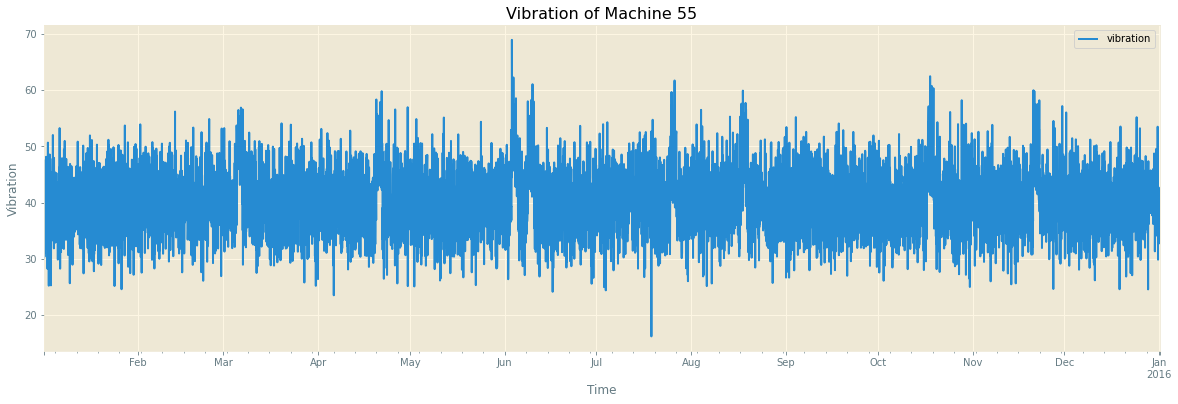

In [10]:
# Let's plot Vibration of Machine 55 for 2015
df_vib_machine_1 = telemetry[
    telemetry.machineID == 55][["datetime", "vibration"]].set_index("datetime")
plot_ts(df_vib_machine_1, title="Vibration of Machine 55", xlabel="Time", ylabel="Vibration")

As an example, below is a plot of voltage values for machine ID=1 for the first half of 2015.

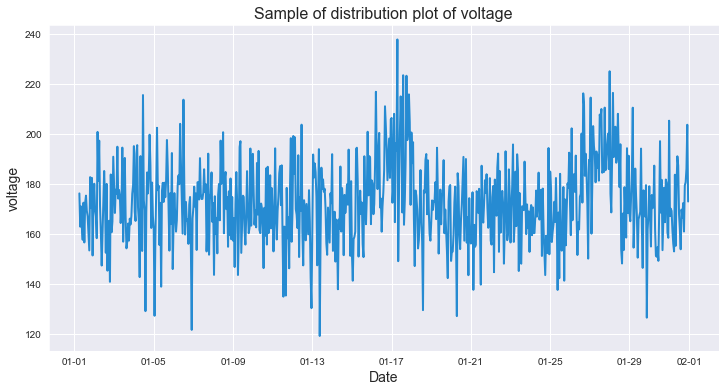

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt']]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage',fontsize=14)

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d'
plt.xlabel('Date',fontsize=14)
plt.title("Sample of distribution plot of voltage", fontsize=16)
plt.show()

<b>Let's plot the distribution of Voltage across Machines.

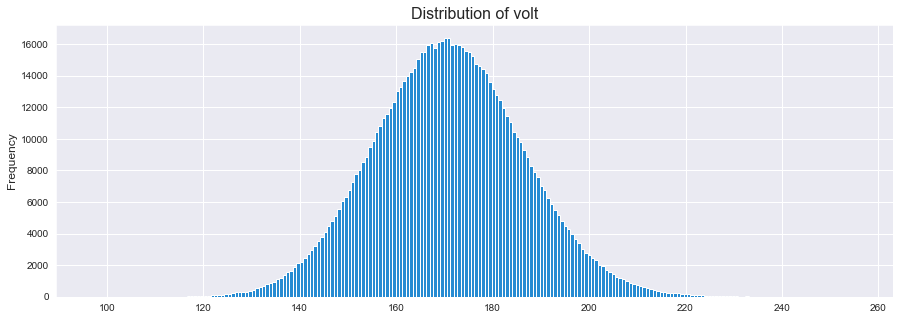

In [12]:
sns.set_style("darkgrid")
plot_hist(telemetry, feature_name="volt", log=False, bins=222)

The distribution is a perfect normal curve.

<b>Let's verify it by plotting histogram of other parameters.

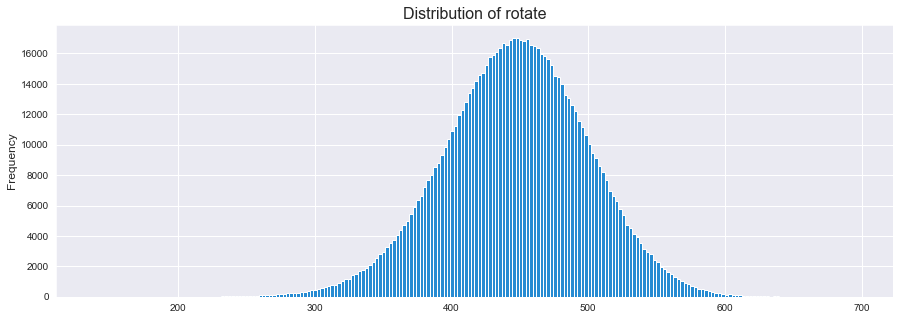

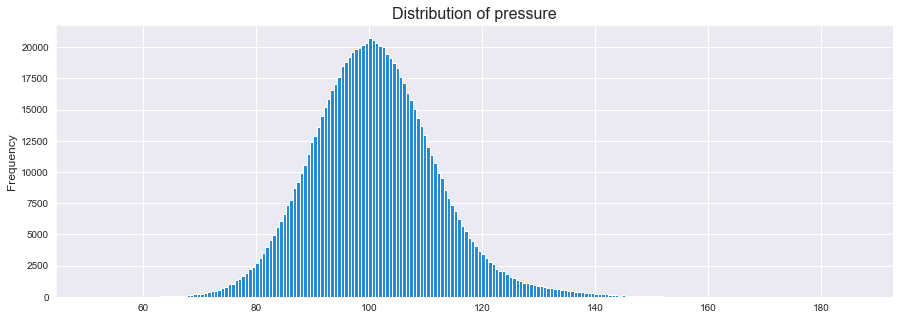

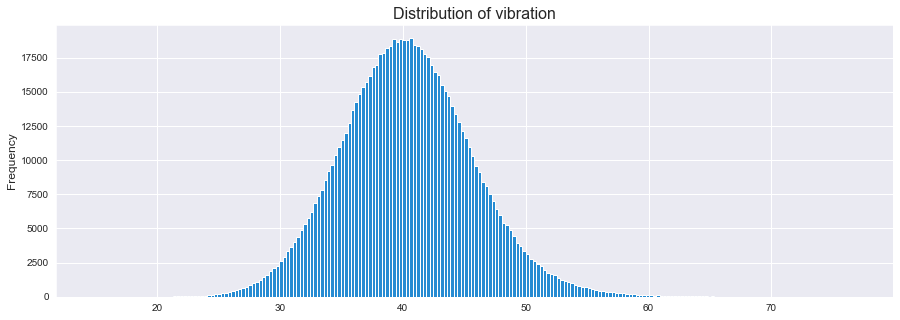

In [13]:
for name in ['rotate', 'pressure', 'vibration']:
    plot_hist(telemetry, feature_name=name, log=False, bins=222)

Vibration, rotation and pressure are also normally distributed.

<b>Observations on Telemetry Data</b>
- The data distributed between 1st Jan 2015 to 1st Jan 2016.
- Each row represents the state of a machine on a particular hour. Voltage, vibration, pressure &       rotation of a machine have been averaged hourly.
- There are 100 unique Machines.
- There are no duplicates or missing values in the dataset.
- The four parameters voltage, vibration, pressure & rotation are normally distributed.

### Errors Dataset (PdM_errors.csv)

This data includes the errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [14]:
# Format datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print("Total number of error records: %d" % len(errors.index))
print(errors.head())

Total number of error records: 3919
             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4


<b>Are there any duplicates?</b><br>
One Machine should not have multiple errors with the same time stamp

In [15]:
check_duplicate(errors, ['datetime', 'machineID', 'errorID'])

0

There are no duplicates in the error data.

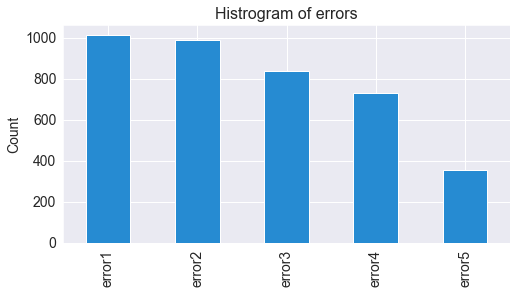

In [16]:
#Plotting the histrogram of errors.
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar', fontsize=14)
plt.title("Histrogram of errors", fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.show()

Type 1 & 2 errors are most frequent

###  Maintenance (PdM_maint.csv)

If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations:

- During the regular scheduled visit, the technician replaced it (Proactive Maintenance)
- A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [17]:
# Format datetime field which comes in as string
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print("Total number of maintenance records: %d" % len(maint.index))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


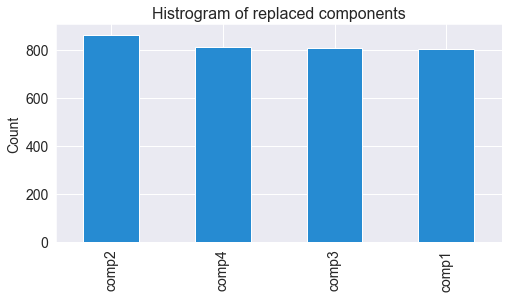

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Histrogram of replaced components", fontsize=16)
plt.show()

Four types components are replaced almost in the same numbers.

### Metadata of Machines (PdM_Machines.csv)

This data set includes some information about the machines: model type and age (years in service).

In [19]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


<b>Create a Data Frame with number of errors, maintenance records and failure records across machines.

In [20]:
# Create a DF with number of errors, maintenance records and failure records across machines

# Create a DF consisting of number of erros across Machines
erros_across_machine = errors.groupby("machineID").size()
erros_across_machine = pd.DataFrame(erros_across_machine, columns=["num_errors"]).reset_index()

machines_errors_df = pd.merge(machines, erros_across_machine, how='left', on="machineID")

# Create a DF consisting of number of maintenance records across Machines
maint_across_machine = maint.groupby("machineID").size()
maint_across_machine = pd.DataFrame(maint_across_machine, columns=["num_maint"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, maint_across_machine, how='left', on="machineID")

# Create a DF consisting of number of failure records across Machines
failure_across_machine = failures.groupby("machineID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["num_failure"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="machineID")

machines_errors_df.head()

,machineID,model,age,num_errors,num_maint,num_failure
0,1,model3,18,35,37,7.0
1,2,model4,7,28,32,4.0
2,3,model3,8,39,37,5.0
3,4,model3,7,31,33,6.0
4,5,model3,2,38,35,7.0


Let's compute correlation values in machines_errors_df.

In [21]:
machines_errors_df.corr()

,machineID,age,num_errors,num_maint,num_failure
machineID,1.000000,0.100196,0.107982,-0.077903,0.096496
age,0.100196,1.000000,0.106931,0.075445,0.476459
num_errors,0.107982,0.106931,1.000000,-0.026558,0.483735
num_maint,-0.077903,0.075445,-0.026558,1.000000,-0.030258
num_failure,0.096496,0.476459,0.483735,-0.030258,1.000000


From the above table, it is observed that attribute 'age' and 'number errors' have correlation with number of failure.  

###  Failures (PdM_failures.csv)

These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.

In [22]:
# Format datetime field which comes in as string.

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Below is the histogram of the failures due to each component. We see that the most failures happen due to component 2.

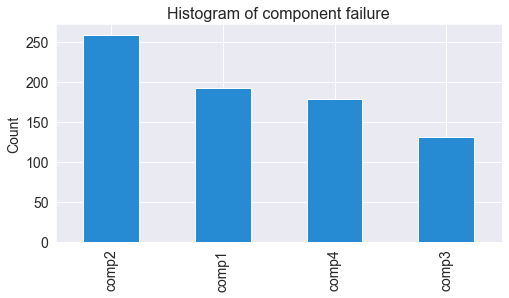

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Histogram of component failure", fontsize=16)
plt.show()

# First Cut Approach:

<b>Objective of this step to predict the failure of machines' components (comp1, comp2 etc.) based on available data without performing feature engineering and hyper-parameter tuning of model. <br>
   Steps to be followed:</b>
1. Load all the data sets
2. Perform one hot encoding for categorical attributes
3. Merger all the data sets after step no-2.
4. Split the data sets into train, cross validation and test set.
5. Apply Xgboost classifier and random forest classifier on train data set.
6. As the dataset is highly imbalance, so F1 score, Precision, Recall and Confusion matrix will be computed to validate the performance of models.

In [24]:
#Loading all the datasets using Pandas library
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [25]:
# Formating datetime field.
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

In [26]:
telemetry.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [27]:
errors.head(2)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3


In [28]:
errors=pd.get_dummies(errors)
errors.head(2)

,datetime,machineID,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0


In [29]:
maint.head(2)

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4


In [30]:
maint=pd.get_dummies(maint)
maint.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1


In [31]:
machines.head(2)

,machineID,model,age
0,1,model3,18
1,2,model4,7


In [32]:
machines=pd.get_dummies(machines)
machines.head(2)

,machineID,age,model_model1,model_model2,model_model3,model_model4
0,1,18,0,0,1,0
1,2,7,0,0,0,1


In [33]:
failures.head(2)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1


In [34]:
tel_error_merge = telemetry[['datetime', 'machineID']].merge(errors, on=['machineID', 'datetime'], 
                                                         how='outer').fillna(0)

tel_error_merge.head(2)

,datetime,machineID,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0


In [35]:
telemetry.shape

(876100, 6)

In [36]:
tel_error_merge.shape

(876403, 7)

In [37]:
tel_maint_merge = telemetry[['datetime', 'machineID']].merge(maint, on=['machineID', 'datetime'], 
                                                         how='outer').fillna(0)

tel_maint_merge.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0


In [38]:
tel_maint_merge.shape

(877223, 6)

In [39]:
telemetry.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [40]:
tel_maint_mac_merge = tel_maint_merge.merge(machines, on=['machineID'], how='left').fillna(0)

In [41]:
tel_maint_mac_merge.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,18,0,0,1,0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,18,0,0,1,0


In [42]:
tel_maint_mac_merge.shape

(877223, 11)

In [43]:
tel_fail_merge = telemetry[['datetime', 'machineID']].merge(failures, on=['machineID', 'datetime'], 
                                                         how='left')

tel_fail_merge.head(2)

,datetime,machineID,failure
0,2015-01-01 06:00:00,1,NaN
1,2015-01-01 07:00:00,1,NaN


In [44]:
tel_fail_merge.shape

(876142, 3)

In [45]:
final_df = telemetry.merge(tel_error_merge, on=['datetime', 'machineID'], how='left')
final_df = final_df.merge(tel_maint_mac_merge, on=['datetime', 'machineID'], how='left')
final_df = final_df.merge(tel_fail_merge, on=['datetime', 'machineID'], how='left')

In [46]:
final_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,0,0,1,0,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,0,0,1,0,NaN


In [47]:
final_df.shape

(877209, 21)

In [48]:
final_df.tail(2)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
877207,2016-01-01 05:00:00,100,165.475310,413.77167,104.081073,44.835259,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5,0,0,0,1,NaN
877208,2016-01-01 06:00:00,100,171.336037,496.09687,79.095538,37.845245,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5,0,0,0,1,NaN


In [49]:
final_df['failure'] = final_df['failure'].astype('str')
final_df.replace({'nan': "none"}, inplace= True)

In [50]:
final_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,0,0,1,0,none
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,0,0,1,0,none


In [51]:
# #Let's save 'final_df' in csv format

# final_df.to_csv('final_df_first_cut.csv')

In [52]:
X = final_df.drop(['datetime', 'machineID', 'failure'], 1)

In [53]:
X.head(2)

,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4
0,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,0,1,0
1,162.879223,402.747490,95.460525,43.413973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,0,1,0


In [54]:
X_final_train = X.values
X_final_train[1]

array([162.8792229 , 402.74748957,  95.46052538,  43.41397268,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  18.        ,   0.        ,   0.        ,
         1.        ,   0.        ])

In [55]:
y_final=final_df['failure']
y_final.head(2)

0    none
1    none
Name: failure, dtype: object

In [56]:
y_final_train = y_final.values
y_final_train[1]

'none'

In [57]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_final_train, y_final_train,test_size=0.20, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, shuffle=False)

In [59]:
print('X_train Observations: %d' % (len(X_train)))
print('y_train Observations: %d' % (len(y_train)))

print('X_cv Observations: %d' % (len(X_cv)))
print('y_cv Observations: %d' % (len(y_cv)))

print('X_test Observations: %d' % (len(X_test)))
print('y_test Observations: %d' % (len(y_test)))

X_train Observations: 561413
y_train Observations: 561413
X_cv Observations: 140354
y_cv Observations: 140354
X_test Observations: 175442
y_test Observations: 175442


In [60]:
#Reference: AAIC Case_study_2.
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Apply model XGBClassifier

In [61]:
from xgboost import XGBClassifier

x_cfl=XGBClassifier()
x_cfl.fit(X_train,y_train)

C:\Users\medinikb\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:43:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

-------------------- Confusion matrix --------------------


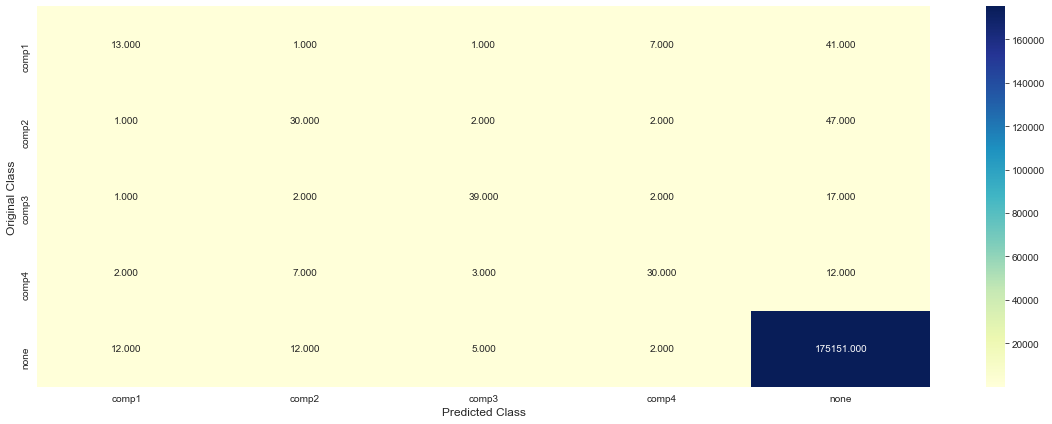

-------------------- Precision matrix (Columm Sum=1) --------------------


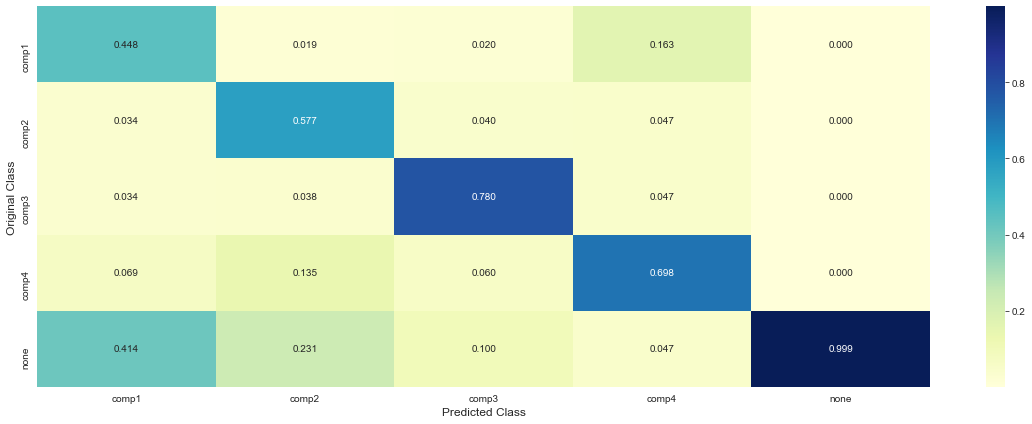

-------------------- Recall matrix (Row sum=1) --------------------


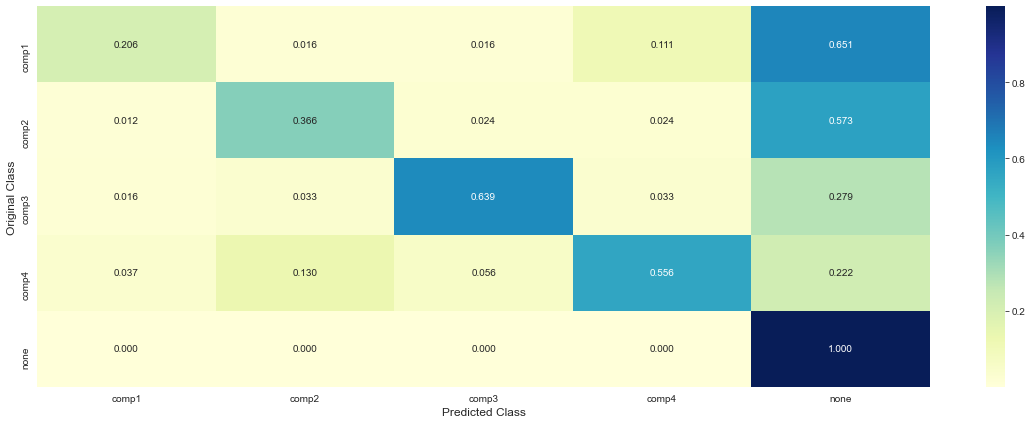

In [62]:
plot_confusion_matrix(y_test, x_cfl.predict(X_test))

## Apply model Random Forest Classifier

In [63]:
%%time
from sklearn.ensemble import RandomForestClassifier

r_cfl=RandomForestClassifier(n_jobs=-1)
r_cfl.fit(X_train,y_train)

Wall time: 39.4 s


RandomForestClassifier(n_jobs=-1)

-------------------- Confusion matrix --------------------


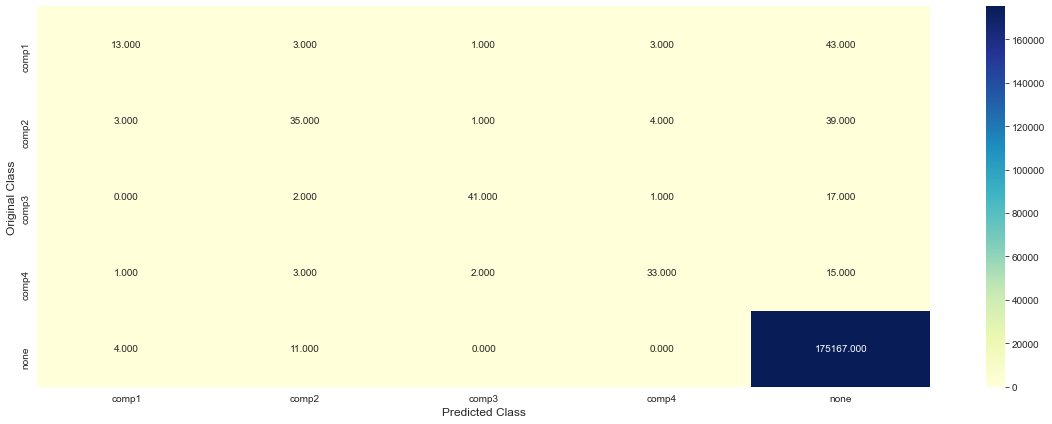

-------------------- Precision matrix (Columm Sum=1) --------------------


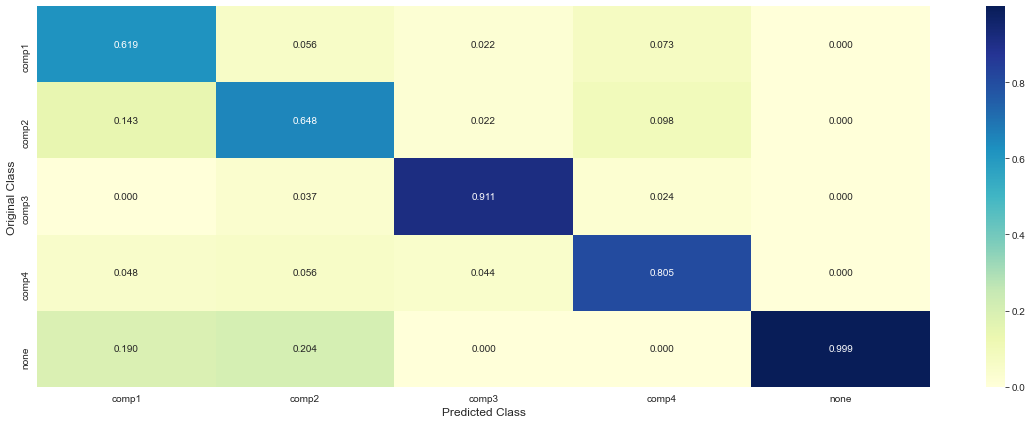

-------------------- Recall matrix (Row sum=1) --------------------


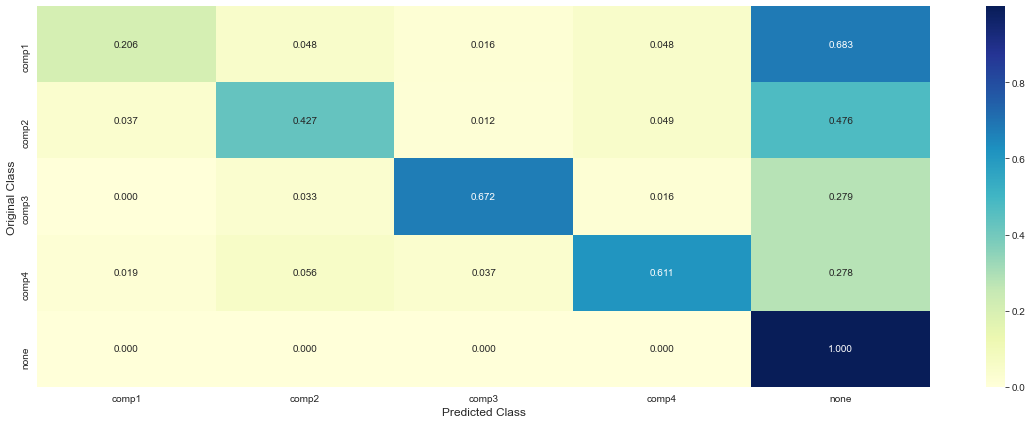

In [64]:
plot_confusion_matrix(y_test, r_cfl.predict(X_test))

In [66]:
from prettytable import PrettyTable

# Specify the Column Names
myTable = PrettyTable(["Model name (Recall score )", "comp1", "comp2", "comp3", 'comp4', 'none(no fail)'])

# Add rows
myTable.add_row(["Xgboost without hyper-parameter tuning", 
                 "0.206", "0.366", "0.639", "0.556", "1"])


myTable.add_row(["Random Forest without hyper-parameter tuning", 
                 "0.206", "0.427", "0.672", "0.611", "1"])


print(myTable)


+----------------------------------------------+-------+-------+-------+-------+---------------+
|          Model name (Recall score )          | comp1 | comp2 | comp3 | comp4 | none(no fail) |
+----------------------------------------------+-------+-------+-------+-------+---------------+
|    Xgboost without hyper-parameter tuning    | 0.206 | 0.366 | 0.639 | 0.556 |       1       |
| Random Forest without hyper-parameter tuning | 0.206 | 0.427 | 0.672 | 0.611 |       1       |
+----------------------------------------------+-------+-------+-------+-------+---------------+


# Observations on First cut approach:
    1. The Recall value of Xgboost and Random Forest model are satisfactory without performing the feature engineering and hyper-parameter tuning. 
    2. After performing EDA, it is observed that this problem can be modeled as time series          problem.
    3. To increase the performance of the ML models, it is better to perform time series          feature engineering technique and do hyper-parameter tuning in the next step. 

# >>>>> End of note book <<<<<<